# 统计所有的研究中的样本数

In [2]:
import pandas as pd
df = pd.read_csv('../../data/metadata_filter.txt',sep='\t')
top_20_projects  = df['project'].value_counts().head(20)

display(top_20_projects)

project
PRJEB11419     22233
qiita_11757     7002
PRJNA729511     3930
PRJNA545312     3566
PRJEB27068      3529
PRJNA685746     3481
PRJNA607574     3285
PRJEB29433      3102
PRJNA548153     3040
PRJEB38948      2956
PRJEB29078      2647
PRJNA491657     2437
PRJNA497734     2168
PRJNA396815     1995
PRJEB5482       1877
PRJNA673102     1842
PRJNA414072     1814
PRJNA510423     1638
PRJNA657821     1589
PRJNA576314     1396
Name: count, dtype: int64

# 从总的数据集中拆分研究的OTU丰度表

In [ ]:
import pandas as pd
import biom
import biom.util
import os

base_path = '../../data/'
biom_path = os.path.join(base_path, 'pretraining_table_filter.biom')
metadata_path = os.path.join(base_path, 'metadata_filter.txt')

# 创建输出目录，如果它不存在的话
output_dir = 'Data/difference_study_training/data'
os.makedirs(output_dir, exist_ok=True)

projects_to_extract = {
    'PRJEB11419': 'table_1.biom',
    'qiita_11757': 'table_2.biom',
    'PRJNA729511': 'table_3.biom',
    'PRJNA545312': 'table_4.biom',
    'PRJEB27068': 'table_5.biom',
    'PRJNA685746': 'table_6.biom',
    'PRJNA607574': 'table_7.biom',
    'PRJEB29433': 'table_8.biom',
    'PRJNA548153': 'table_9.biom',
    'PRJEB38948': 'table_10.biom',
}

# --- 1. 加载并严格统一ID格式 ---
def clean_ids(ids):
    """强制转换为字符串并去除所有空白/不可见字符"""
    return [str(id).strip().replace('\x00', '') for id in ids]

# 加载原始数据
print(f"Loading table from: {biom_path}")
full_table = biom.load_table(biom_path)
print(f"Loading metadata from: {metadata_path}")
metadata_df = pd.read_csv(metadata_path, sep='\t', index_col=0)

# 清洗所有ID
biom_sample_ids_original = clean_ids(full_table.ids(axis='sample'))
metadata_ids = clean_ids(metadata_df.index)

# 重建BIOM表（确保使用清洗后的ID）
print("Reconstructing BIOM table with cleaned IDs...")
full_table = biom.Table(
    full_table.matrix_data,
    observation_ids=clean_ids(full_table.ids(axis='observation')),
    sample_ids=biom_sample_ids_original,
    observation_metadata=[full_table.metadata(id, axis='observation') for id in full_table.ids(axis='observation')],
    sample_metadata=[full_table.metadata(id, axis='sample') for id in full_table.ids(axis='sample')]
)
print(f"Initial table shape: {full_table.shape} (Features, Samples)")


# --- 【新增】去除空行和空列 ---
print("\nRemoving empty rows (features) and columns (samples)...")
# 首先，移除空的行（特征）
full_table.remove_empty(axis='observation', inplace=True)
# 然后，移除空的列（样本）
full_table.remove_empty(axis='sample', inplace=True)
print(f"Table shape after removing empty entries: {full_table.shape} (Features, Samples)")
# --- 新增步骤结束 ---


# --- 2. 使用集合运算确保完全匹配 ---
# 在移除空样本后，重新获取BIOM表中的样本ID集合
full_table_ids_set = set(full_table.ids(axis='sample'))
metadata_df.index = metadata_ids  # 更新metadata的索引

for project_name, output_filename in projects_to_extract.items():
    print(f"\n--- Processing project: {project_name} ---")
    
    # 获取该项目所有样本ID（已清洗）
    project_ids = set(metadata_df[metadata_df['project'] == project_name].index)
    
    # 计算实际存在的样本交集
    valid_ids = list(project_ids & full_table_ids_set)
    
    if not valid_ids:
        print(f"Warning: No valid samples for {project_name} after initial filtering.")
        continue
    
    print(f"Found {len(valid_ids)} valid samples.")
    
    # 【注意】二次验证循环可以简化。因为我们已经从 full_table_ids_set 中获取了交集，
    # 这里的 'try-except' 块是一种非常安全的冗余检查，可以保留。
    final_ids = []
    for sid in valid_ids:
        try:
            # 显式尝试访问样本（最严格的检查）
            _ = full_table.metadata(sid, axis='sample')
            final_ids.append(sid)
        except:
            print(f"Sample {sid} metadata access failed, excluding")
    
    if not final_ids:
        print("No samples passed final validation")
        continue
    
    # 执行过滤
    filtered_table = full_table.filter(final_ids, axis='sample', inplace=False)
    filtered_table.remove_empty(axis='observation', inplace=True)
    filtered_table.remove_empty(axis='sample', inplace=True)
    print(f"Filtered table shape: {filtered_table.shape}")
    
    # 构建完整的输出路径
    output_path = os.path.join(output_dir, output_filename)
    
    # 保存
    with biom.util.biom_open(output_path, 'w') as f:
        filtered_table.to_hdf5(f, f"Filtered for {project_name}")
    print(f"Saved to {output_path}")

print("\n=== All operations completed ===")

In [3]:
import pandas as pd
import biom
import biom.util
import os

base_path = '../../data/'
biom_path = os.path.join(base_path, 'pretraining_table_rarefaction.biom')
metadata_path = os.path.join(base_path, 'metadata_filter.txt')

# 创建输出目录，如果它不存在的话
output_dir = 'Data/difference_study_training/data_rarefaction'
os.makedirs(output_dir, exist_ok=True)

projects_to_extract = {
    'PRJEB11419': 'table_1.biom',
    'qiita_11757': 'table_2.biom',
    'PRJNA729511': 'table_3.biom',
    'PRJNA545312': 'table_4.biom',
    'PRJEB27068': 'table_5.biom',
    'PRJNA685746': 'table_6.biom',
    'PRJNA607574': 'table_7.biom',
    'PRJEB29433': 'table_8.biom',
    'PRJNA548153': 'table_9.biom',
    'PRJEB38948': 'table_10.biom',
}

# --- 1. 加载并严格统一ID格式 ---
def clean_ids(ids):
    """强制转换为字符串并去除所有空白/不可见字符"""
    return [str(id).strip().replace('\x00', '') for id in ids]

# 加载原始数据
print(f"Loading table from: {biom_path}")
full_table = biom.load_table(biom_path)
print(f"Loading metadata from: {metadata_path}")
metadata_df = pd.read_csv(metadata_path, sep='\t', index_col=0)

# 清洗所有ID
biom_sample_ids_original = clean_ids(full_table.ids(axis='sample'))
metadata_ids = clean_ids(metadata_df.index)

# 重建BIOM表（确保使用清洗后的ID）
print("Reconstructing BIOM table with cleaned IDs...")
full_table = biom.Table(
    full_table.matrix_data,
    observation_ids=clean_ids(full_table.ids(axis='observation')),
    sample_ids=biom_sample_ids_original,
    observation_metadata=[full_table.metadata(id, axis='observation') for id in full_table.ids(axis='observation')],
    sample_metadata=[full_table.metadata(id, axis='sample') for id in full_table.ids(axis='sample')]
)
print(f"Initial table shape: {full_table.shape} (Features, Samples)")


# --- 2. 对总表进行去空处理 ---
print("\nRemoving empty entries from the main table...")
full_table.remove_empty(axis='observation', inplace=True)
full_table.remove_empty(axis='sample', inplace=True)
print(f"Main table shape after cleaning: {full_table.shape} (Features, Samples)")


# --- 3. 循环拆分并再次对子表去空 ---
full_table_ids_set = set(full_table.ids(axis='sample'))
metadata_df.index = metadata_ids

for project_name, output_filename in projects_to_extract.items():
    print(f"\n--- Processing project: {project_name} ---")
    
    project_ids = set(metadata_df[metadata_df['project'] == project_name].index)
    valid_ids = list(project_ids & full_table_ids_set)
    
    if not valid_ids:
        print(f"Warning: No valid samples for {project_name}.")
        continue
    
    print(f"Found {len(valid_ids)} valid samples.")
    
    # 执行过滤，创建子表
    filtered_table = full_table.filter(valid_ids, axis='sample', inplace=False)
    print(f"Subset table shape before final cleaning: {filtered_table.shape}")
    
    # --- 【新增】对拆分后的每个子表再次进行去空处理 ---
    #
    # 这一步很关键，因为按样本过滤后，某些特征在子表中可能变为空行
    filtered_table.remove_empty(axis='observation', inplace=True)
    filtered_table.remove_empty(axis='sample', inplace=True)
    print(f"Subset table shape after final cleaning: {filtered_table.shape}")
    # --- 新增步骤结束 ---
    
    # 构建完整的输出路径
    output_path = os.path.join(output_dir, output_filename)
    
    # 保存
    with biom.util.biom_open(output_path, 'w') as f:
        filtered_table.to_hdf5(f, f"Filtered for {project_name}")
    print(f"Saved to {output_path}")

print("\n=== All operations completed ===")

Loading table from: ../../data/pretraining_table_rarefaction.biom
Loading metadata from: ../../data/metadata_filter.txt
Reconstructing BIOM table with cleaned IDs...
Initial table shape: (12596, 210524) (Features, Samples)

Removing empty entries from the main table...
Main table shape after cleaning: (12596, 210524) (Features, Samples)

--- Processing project: PRJEB11419 ---
Found 22233 valid samples.
Subset table shape before final cleaning: (12596, 22233)
Subset table shape after final cleaning: (6326, 22233)
Saved to Data/difference_study_training/data_rarefaction/table_1.biom

--- Processing project: qiita_11757 ---
Found 7002 valid samples.
Subset table shape before final cleaning: (12596, 7002)
Subset table shape after final cleaning: (4699, 7002)
Saved to Data/difference_study_training/data_rarefaction/table_2.biom

--- Processing project: PRJNA729511 ---
Found 3930 valid samples.
Subset table shape before final cleaning: (12596, 3930)
Subset table shape after final cleaning: (

# 绘制热力图，总的数据集训练出来的embedding和其他研究作为数据集训练出来的embedding的相似性

/tmp/ipykernel_283482/3793612104.py:103: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df_plot.pivot_table(
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following

成功读取文件: Data/difference_study_training/mantel_test_results.csv
在文件中识别出的距离度量: abundance percentile, abundance totalsum, braycurtis percentile, braycurtis totalsum, faith, jaccard, russell rao, russell rao weight

--- 正在生成最终版热图 (Final Heatmap) ---
已设定Study（列）的显示顺序为: PRJEB11419
(22233), qiita_11757
(7002), PRJNA729511
(3930), PRJNA545312
(3566), PRJEB27068
(3529), PRJNA685746
(3481), PRJNA607574
(3285), PRJEB29433
(3102), PRJNA548153
(3040), PRJEB38948
(2956)
已按R均值对Metric（行）进行排序，顺序为: Co-Abundance Percentile, Co-Abundance Totalsum, Russell Rao Weight, Russell Rao, Braycurtis Totalsum, Braycurtis Percentile, Faith, Jaccard


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun


成功保存最终版热图: Figures/17_heatmap_final_tweaks.png


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

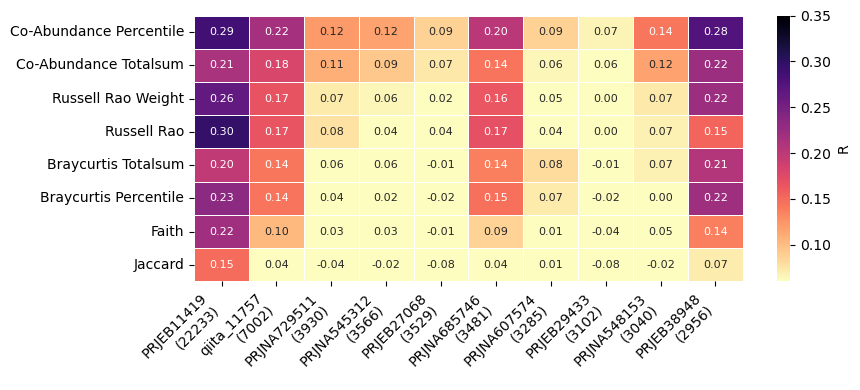


所有分析和绘图完成！


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import numpy as np

# --- 配置区 (Configuration) ---

# 1. 定义您的CSV文件名
CSV_FILE_PATH = 'Data/difference_study_training/mantel_test_results.csv'

# 2. 定义所有可能出现的距离度量类型
DISTANCE_TYPES = [
    'abundance percentile', 'abundance totalsum', 'braycurtis percentile',
    'braycurtis totalsum', 'faith', 'jaccard', 'russell rao', 'russell rao weight'
]

# 3. 定义样本量与编号的映射关系 (这将决定Study的原始顺序)
SAMPLE_SIZE_MAP = {
    0: '20w', 1: 'PRJEB11419\n(22233)', 2: 'qiita_11757\n(7002)', 3: 'PRJNA729511\n(3930)', 4: 'PRJNA545312\n(3566)',
    5: 'PRJEB27068\n(3529)', 6: 'PRJNA685746\n(3481)', 7: 'PRJNA607574\n(3285)', 
    8: 'PRJEB29433\n(3102)', 9: 'PRJNA548153\n(3040)', 10: 'PRJEB38948\n(2956)'
}
# PRJEB11419     22233
# qiita_11757     7002
# PRJNA729511     3930
# PRJNA545312     3566
# PRJEB27068      3529
# PRJNA685746     3481
# PRJNA607574     3285
# PRJEB29433      3102
# PRJNA548153     3040
# PRJEB38948      2956
# 4. 定义输出图表保存的文件夹名称
OUTPUT_DIR = 'Figures'


# --- 核心功能函数 (Core Functions) ---
# 此函数与您之前提供的一致，无需修改
def prepare_data_vectorized(csv_path):
    """
    读取并使用向量化操作高效地预处理数据，为绘图做准备。
    """
    try:
        df = pd.read_csv(csv_path)
        print(f"成功读取文件: {csv_path}")
    except FileNotFoundError:
        print(f"错误: 找不到文件 '{csv_path}'。请检查文件名和路径。")
        return None

    # --- 数据清洗与提取 (向量化) ---
    sorted_distance_types = sorted(DISTANCE_TYPES, key=len, reverse=True)
    metric_pattern = f"({'|'.join(sorted_distance_types)})"
    df['metric'] = df['Matrix 1'].str.extract(metric_pattern, expand=False)
    df.dropna(subset=['metric'], inplace=True)
    
    found_metrics = sorted(df['metric'].unique())
    if not found_metrics:
        print("错误: 未能在'Matrix 1'列中找到任何已定义的距离度量。")
        return None
    print(f"在文件中识别出的距离度量: {', '.join(found_metrics)}")

    df['idx1'] = df['Matrix 1'].str.extract(r'-(\d+)$').astype(int)
    df['idx2'] = df['Matrix 2'].str.extract(r'-(\d+)$').astype(int)

    is_comp_with_0 = ((df['idx1'] == 0) & (df['idx2'] != 0)) | \
                     ((df['idx2'] == 0) & (df['idx1'] != 0))
    df_filtered = df[is_comp_with_0].copy()

    df_filtered['comparison_idx'] = np.where(df_filtered['idx1'] == 0, df_filtered['idx2'], df_filtered['idx1'])
    df_filtered['Comparison'] = df_filtered['comparison_idx'].map(SAMPLE_SIZE_MAP)
    df_filtered['Metric'] = df_filtered['metric'].str.replace('_', ' ').str.title()
    
    df_plot = df_filtered[['Metric', 'Comparison', 'R_value']].copy()

    if df_plot.empty:
        print("错误: 未能提取任何有效的绘图数据。请检查CSV文件内容和格式。")
        return None

    return df_plot


# --- 绘图函数 (Plotting Function) ---

def plot_heatmap(df_plot, output_dir):
    """
    根据处理好的数据，绘制热图，以提供全局视角。
    Y轴为距离度量，X轴为研究项目，颜色为Mantel R值。
    """
    print("\n--- 正在生成最终版热图 (Final Heatmap) ---")
    
    # 1. 数据预处理
    df_plot['Metric'] = df_plot['Metric'].str.replace('Abundance', 'Co-Abundance')
    study_order = [v for k, v in sorted(SAMPLE_SIZE_MAP.items()) if k != 0]
    df_plot['Comparison'] = pd.Categorical(df_plot['Comparison'], categories=study_order, ordered=True)
    df_plot.dropna(subset=['Comparison'], inplace=True)
    df_plot.sort_values('Comparison', inplace=True)
    print(f"已设定Study（列）的显示顺序为: {', '.join(study_order)}")

    # 2. 转换数据格式并排序
    try:
        heatmap_data = df_plot.pivot_table(
            index='Metric',
            columns='Comparison',
            values='R_value'
        )
        mean_r_values = heatmap_data.mean(axis=1)
        sorted_metric_order = mean_r_values.sort_values(ascending=False).index
        heatmap_data = heatmap_data.loc[sorted_metric_order]
        print(f"已按R均值对Metric（行）进行排序，顺序为: {', '.join(sorted_metric_order)}")
        
    except Exception as e:
        print(f"错误：创建热图数据透视表失败。错误信息: {e}")
        return

    # 4. 开始绘图
    fig, ax = plt.subplots(figsize=(9, 4)) # 调整尺寸以优化布局
    sns.heatmap(
        heatmap_data,
        annot=True,               # 保持显示数值
        fmt=".2f",
        linewidths=.5,
        vmin=0.06,                # 您可以根据需要调整
        vmax=0.35,                 # 您可以根据需要调整
        ax=ax,
        
        # --- 以下是根据您的新需求进行的核心修改 ---
        
        # 1. 调整注释文字大小
        annot_kws={'size': 8},  # 将格子里的数字大小设置为8，您可以改成7, 9等
        
        # 2. 更改颜色方案：高值为深色，低值为浅色
        cmap='magma_r',         # 使用 'magma' 的反转色，'_r'代表 'reversed'
        
        # 3. 为颜色条（图例）添加标题
        cbar_kws={'label': 'R'}
    )

    # 5. 美化图表
    ax.set_title('', fontsize=18, weight='bold', pad=20)
    ax.set_xlabel('', fontsize=12, labelpad=10)
    ax.set_ylabel('', fontsize=12, labelpad=10)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    fig.tight_layout() # 自动调整布局以适应所有元素，包括颜色条标题

    # 6. 保存图表
    filepath = os.path.join(output_dir, '17_heatmap_final_tweaks.png') # 使用新文件名保存
    try:
        fig.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"\n成功保存最终版热图: {filepath}")
    except Exception as e:
        print(f"\n保存文件时出错: {e}")

    plt.show()


# --- 主程序入口 ---

if __name__ == '__main__':
    # 设置matplotlib以正确显示中文和负号
    try:
        plt.rcParams['font.sans-serif'] = ['SimHei']
        plt.rcParams['axes.unicode_minus'] = False
    except Exception as e:
        print(f"设置中文字体失败，将使用默认字体。错误: {e}")
        
    # 创建输出文件夹
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
        print(f"创建文件夹: {OUTPUT_DIR}")
        
    # 加载并预处理数据
    df_for_plotting = prepare_data_vectorized(CSV_FILE_PATH)
    
    # 检查数据是否成功加载，然后调用绘图函数
    if df_for_plotting is not None:
        plot_heatmap(df_for_plotting, OUTPUT_DIR)
    
    print("\n所有分析和绘图完成！")